In [12]:
from copy import deepcopy

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from elasticsearch import Elasticsearch
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy import stats

from algorithm.co_occ import IterConstructor, BFSConstructor
from algorithm.const import *
from algorithm.profile import profile


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 设置中文字体，并保证负号正常显示

plt.rcParams['font.sans-serif'] = ['Calibri']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("white")


In [13]:
es = Elasticsearch("http://127.0.0.1:9204")
es.info()

ObjectApiResponse({'name': 'node0', 'cluster_name': 'docbase', 'cluster_uuid': '63TQlJkjRvyY3NtujxmYuQ', 'version': {'number': '8.6.1', 'build_flavor': 'default', 'build_type': 'zip', 'build_hash': '180c9830da956993e59e2cd70eb32b5e383ea42c', 'build_date': '2023-01-24T21:35:11.506992272Z', 'build_snapshot': False, 'lucene_version': '9.4.2', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [14]:
constructors = [
    IterConstructor(client=es),
    BFSConstructor(client=es)
]
constructors


[0x1E101D2ADC0 co_occ_test content, 0x1E101D2A700 co_occ_test content]

In [15]:
top_words = {
    "top_words": {
        "terms": {
            "field": "content",
            "size": 200,
        }
    }
}
res = es.search(
    index=DEFAULT_INDEX,
    aggs=top_words, size=0
)
buckets = [
    bucket for bucket in
    res["aggregations"]["top_words"]["buckets"]
    if len(bucket["key"]) > 1
]
buckets[:3]

[{'key': '图书馆', 'doc_count': 667},
 {'key': '研究', 'doc_count': 465},
 {'key': '我国', 'doc_count': 445}]

In [16]:
profiles = []
for constructor in constructors:
    for bucket in buckets:
        query = {
            "bool": {
                "must": [
                    {
                        "wildcard": {
                            DEFAULT_FIELD: f"*{bucket['key']}*"
                        }
                    }
                ]
            }
        }
        constructor = profile(constructor)
        network_t = constructor.get_network_time(query)
        network_m = constructor.get_network_memory(query)
        bucket["time"] = network_t.time
        bucket["memory"] = network_m.memory
        bucket["algorithm"] = str(type(constructor))
        profiles.append(deepcopy(bucket))
profiles[:3]

[{'key': '图书馆',
  'doc_count': 667,
  'time': 3.0250814000028186,
  'memory': 6949.3203125,
  'algorithm': "<class 'algorithm.co_occ.IterConstructor'>"},
 {'key': '研究',
  'doc_count': 465,
  'time': 2.2192556000009063,
  'memory': 7342.1953125,
  'algorithm': "<class 'algorithm.co_occ.IterConstructor'>"},
 {'key': '我国',
  'doc_count': 445,
  'time': 0.7130216000005021,
  'memory': 1924.640625,
  'algorithm': "<class 'algorithm.co_occ.IterConstructor'>"}]

In [17]:
profile_data = pd.DataFrame(profiles)
profile_data["algorithm"] = profile_data["algorithm"].map({
    str(IterConstructor): "Original",
    str(BFSConstructor): "Optimized"
})
profile_data.head()

,key,doc_count,time,memory,algorithm
0,图书馆,667,3.025081,6949.320312,Original
1,研究,465,2.219256,7342.195312,Original
2,我国,445,0.713022,1924.640625,Original
3,思考,341,0.603422,2701.937500,Original
4,报道,333,0.777444,4512.476562,Original


(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x1e101b684c0>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x1e1062ab970>)

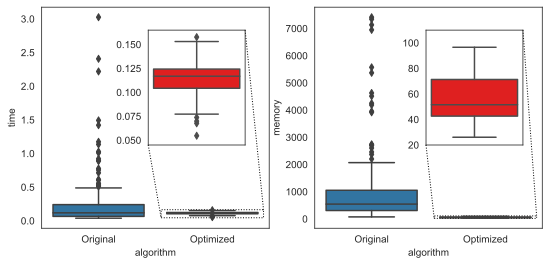

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

sns.boxplot(data=profile_data, y="time", x="algorithm", ax=axes[0])
sns.boxplot(data=profile_data, y="memory", x="algorithm", ax=axes[1])

pos = [0.29, 0.4, 0.15, 0.4]
ax1: plt.Axes = fig.add_axes(pos)
sns.boxplot(data=profile_data, y="time", x="algorithm", ax=ax1, color="r")
ax1.set_xlim(0.55, 1.45)
ax1.set_ylim(0.045, .165)
ax1.get_xaxis().set_visible(False)
ax1.set_ylabel("")
mark_inset(axes[0], ax1, loc1=3, loc2=1, ec='k', lw=1, linestyle=":")

pos = [0.72, 0.4, 0.15, 0.4]
ax2 = fig.add_axes(pos)
sns.boxplot(data=profile_data, y="memory", x="algorithm", ax=ax2, color="r")
ax2.set_xlim(0.55, 1.45)
ax2.set_ylim(20, 110)
ax2.get_xaxis().set_visible(False)
ax2.set_ylabel("")
mark_inset(axes[1], ax2, loc1=3, loc2=1, ec='k', lw=1, linestyle=":")


In [19]:
profile_iter = profile_data[profile_data["algorithm"] == "Original"]
profile_bfs = profile_data[profile_data["algorithm"] == "Optimized"]


In [20]:
profile_iter.describe()

,doc_count,time,memory
count,187.000000,187.000000,187.000000
mean,78.962567,0.250151,1013.743692
std,80.005939,0.390315,1338.128283
min,35.000000,0.038843,74.109375
25%,40.500000,0.066044,308.957031
50%,50.000000,0.118844,545.070312
75%,79.000000,0.240625,1053.769531
max,667.000000,3.025081,7414.390625


In [21]:
profile_bfs.describe()

,doc_count,time,memory
count,187.000000,187.000000,187.000000
mean,78.962567,0.114120,56.106409
std,80.005939,0.017097,16.783023
min,35.000000,0.054684,26.078125
25%,40.500000,0.104273,42.652344
50%,50.000000,0.116872,51.554688
75%,79.000000,0.124316,71.328125
max,667.000000,0.157712,96.593750


In [22]:
print(
    "Wilcoxon signed rank test:\n",
    stats.wilcoxon(profile_iter["time"], profile_bfs["time"])
)
print(
    "Mann-Whitney rank test:\n",
    stats.mannwhitneyu(profile_iter["memory"], profile_bfs["memory"])
)

Wilcoxon signed rank test:
 WilcoxonResult(statistic=5809.0, pvalue=5.801439450453057e-05)
Mann-Whitney rank test:
 MannwhitneyuResult(statistic=34930.0, pvalue=1.6023274721330694e-62)


<Axes: xlabel='doc_count', ylabel='memory'>

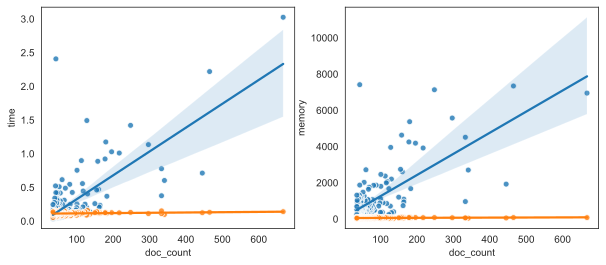

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
sns.regplot(
    data=profile_iter,
    x="doc_count", y="time", ax=ax,
    scatter_kws={"linewidth": 1, "edgecolor": "w"}
)
sns.regplot(
    data=profile_bfs,
    x="doc_count", y="time", ax=ax,
    scatter_kws={"linewidth": 1, "edgecolor": "w"}
)

ax = axes[1]
sns.regplot(
    data=profile_iter,
    x="doc_count", y="memory", ax=ax,
    scatter_kws={"linewidth": 1, "edgecolor": "w"}
)
sns.regplot(
    data=profile_bfs,
    x="doc_count", y="memory", ax=ax,
    scatter_kws={"linewidth": 1, "edgecolor": "w"}
)
